In [2]:
# Fraud Detection - Data Preprocessing (Task 1 Completion)
# Complete data transformation pipeline for:
 # 1. Handling Class Imbalance
 # 2. Feature Scaling
 # 3. Categorical Encoding

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPipeline 
import os
## 1. Load Processed Data
# Load your preprocessed data
fraud_data = pd.read_csv('../data/processed/fraud_data_final.csv')
credit_data = pd.read_csv('../data/processed/credit_data_final.csv')

Fraud Data Class Distribution:


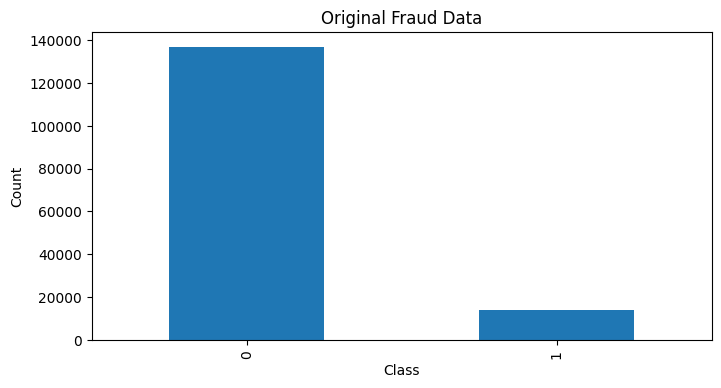


Credit Data Class Distribution:


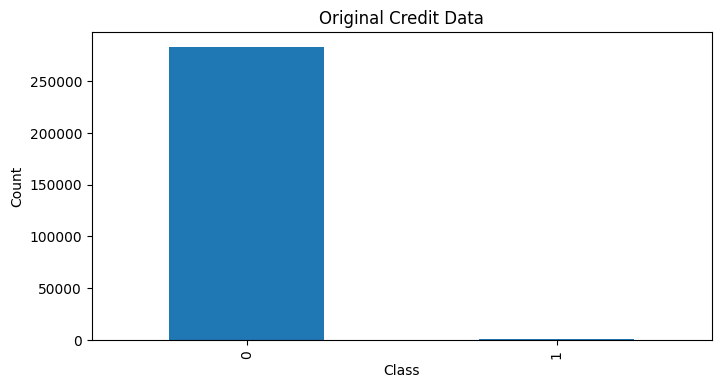

In [3]:
## Cell 2: Class Distribution Analysis Visualize class imbalance before any processing
def plot_class_distribution(y, title):
    plt.figure(figsize=(8, 4))
    y.value_counts().plot(kind='bar')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

print("Fraud Data Class Distribution:")
plot_class_distribution(fraud_data['class'], 'Original Fraud Data')
print("\nCredit Data Class Distribution:")
plot_class_distribution(credit_data['Class'], 'Original Credit Data')

In [5]:
## Cell 3: Prepare Data for Transformation Handle datetime columns and separate features/target
def prepare_data(df, target_col):
    """Convert datetimes to numeric and split features/target"""
    df = df.copy()
    
    # Convert datetime to numeric (Unix timestamp)
    datetime_cols = df.select_dtypes(include=['datetime']).columns
    for col in datetime_cols:
        df[col] = pd.to_numeric(df[col])
    
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    return X, y

# Prepare fraud data
X_fraud, y_fraud = prepare_data(fraud_data, 'class')

# Prepare credit data
X_credit, y_credit = prepare_data(credit_data, 'Class')

In [6]:

# Identify numerical and categorical columns
def get_column_types(X):
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(include='object').columns.tolist()
    return numerical_cols, categorical_cols

# Create preprocessor for fraud data
numerical_cols_fraud, categorical_cols_fraud = get_column_types(X_fraud)
preprocessor_fraud = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_fraud),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_fraud)
    ],
    remainder='passthrough' # Keep other columns (if any, like already numerical ones not specified)
)

# Create preprocessor for credit data
numerical_cols_credit, categorical_cols_credit = get_column_types(X_credit)
preprocessor_credit = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_credit),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_credit)
    ],
    remainder='passthrough'
)

Fraud Data - Building SMOTE Pipeline:


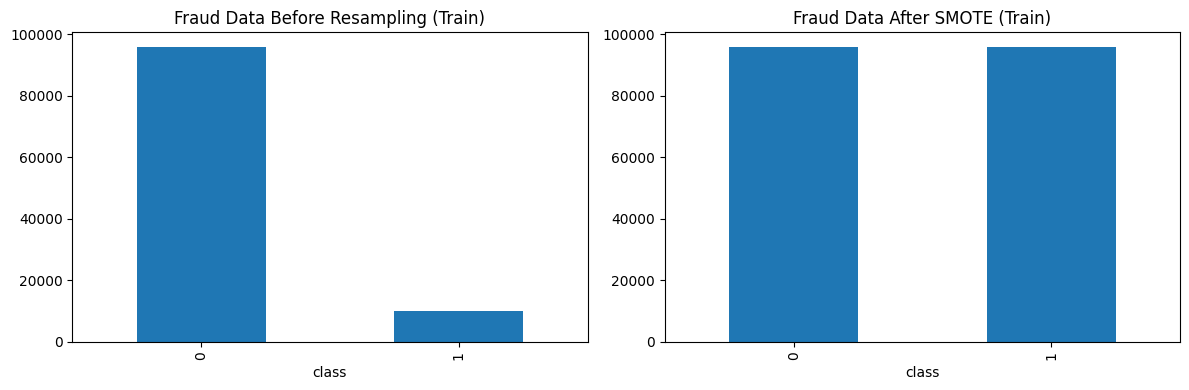


Fraud Data - X_train_fraud_transformed shape: (191744, 309466)
Fraud Data - y_train_fraud_resampled shape: (191744,)
Fraud Data - X_test_fraud_transformed shape: (45334, 309466)
Fraud Data - y_test_fraud shape: (45334,)

Credit Data - Building Random Undersampling Pipeline:


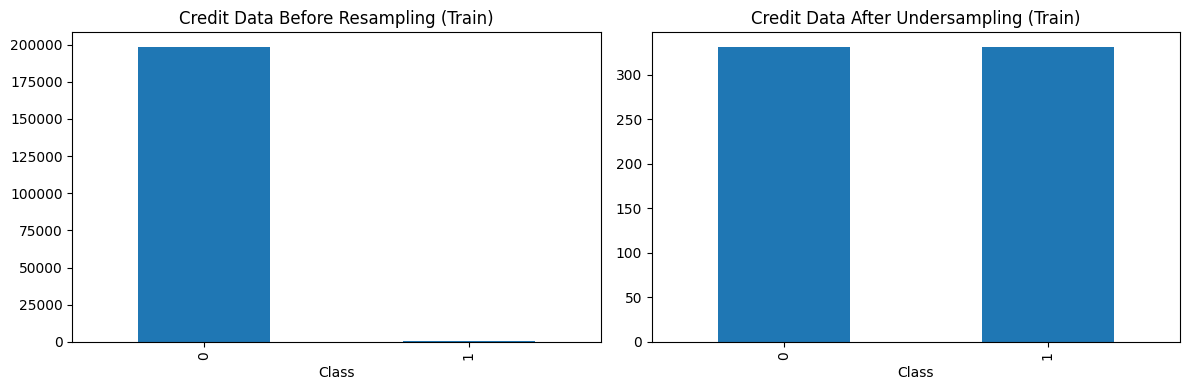


Credit Data - X_train_credit_transformed shape: (662, 39)
Credit Data - y_train_credit_resampled shape: (662,)
Credit Data - X_test_credit_transformed shape: (85118, 39)
Credit Data - y_test_credit shape: (85118,)

--- Justification of Data Transformation Choices ---
1. Handling Class Imbalance:
   - Fraud Data: SMOTE (Synthetic Minority Over-sampling Technique) was chosen. Fraud datasets typically have a very small percentage of fraudulent transactions (minority class). SMOTE creates synthetic samples of the minority class, helping to balance the dataset without simply replicating existing samples. This helps the model learn the patterns of the minority class more effectively.
   - Credit Data: Random Undersampling was chosen. This dataset might have a larger absolute number of minority class instances than fraud data, or the goal might be to reduce the overall dataset size while balancing. Random undersampling removes samples from the majority class. While it can lead to loss of inf

In [7]:
## Cell 5: Complete Data Transformation Pipeline (Handling Imbalance, Scaling, Encoding)

def create_full_pipeline(preprocessor, sampler_method='smote', random_state=42):
    """
    Creates a full data transformation pipeline including preprocessing and resampling.
    """
    if sampler_method == 'smote':
        sampler = SMOTE(random_state=random_state)
    elif sampler_method == 'undersample':
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        raise ValueError("Invalid sampler_method. Choose 'smote' or 'undersample'.")

    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('sampler', sampler)
    ])
    return pipeline

# Apply to fraud data (SMOTE)
print("Fraud Data - Building SMOTE Pipeline:")
full_pipeline_fraud = create_full_pipeline(preprocessor_fraud, sampler_method='smote')

# Split data before applying the full pipeline
X_train_fraud_raw, X_test_fraud_raw, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud
)

# Fit and transform only on training data
X_train_fraud_transformed, y_train_fraud_resampled = full_pipeline_fraud.fit_resample(X_train_fraud_raw, y_train_fraud)

# Transform test data (no resampling on test data)
X_test_fraud_transformed = preprocessor_fraud.transform(X_test_fraud_raw)


# Visualize Fraud Data Resampling Result
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
y_train_fraud.value_counts().plot(kind='bar', title='Fraud Data Before Resampling (Train)')
plt.subplot(1, 2, 2)
pd.Series(y_train_fraud_resampled).value_counts().plot(kind='bar', title='Fraud Data After SMOTE (Train)')
plt.tight_layout()
plt.show()

print(f"\nFraud Data - X_train_fraud_transformed shape: {X_train_fraud_transformed.shape}")
print(f"Fraud Data - y_train_fraud_resampled shape: {y_train_fraud_resampled.shape}")
print(f"Fraud Data - X_test_fraud_transformed shape: {X_test_fraud_transformed.shape}")
print(f"Fraud Data - y_test_fraud shape: {y_test_fraud.shape}")


# Apply to credit data (Undersampling)
print("\nCredit Data - Building Random Undersampling Pipeline:")
full_pipeline_credit = create_full_pipeline(preprocessor_credit, sampler_method='undersample')

# Split data before applying the full pipeline
X_train_credit_raw, X_test_credit_raw, y_train_credit, y_test_credit = train_test_split(
    X_credit, y_credit, test_size=0.3, random_state=42, stratify=y_credit
)

# Fit and transform only on training data
X_train_credit_transformed, y_train_credit_resampled = full_pipeline_credit.fit_resample(X_train_credit_raw, y_train_credit)

# Transform test data (no resampling on test data)
X_test_credit_transformed = preprocessor_credit.transform(X_test_credit_raw)


# Visualize Credit Data Resampling Result
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
y_train_credit.value_counts().plot(kind='bar', title='Credit Data Before Resampling (Train)')
plt.subplot(1, 2, 2)
pd.Series(y_train_credit_resampled).value_counts().plot(kind='bar', title='Credit Data After Undersampling (Train)')
plt.tight_layout()
plt.show()

print(f"\nCredit Data - X_train_credit_transformed shape: {X_train_credit_transformed.shape}")
print(f"Credit Data - y_train_credit_resampled shape: {y_train_credit_resampled.shape}")
print(f"Credit Data - X_test_credit_transformed shape: {X_test_credit_transformed.shape}")
print(f"Credit Data - y_test_credit shape: {y_test_credit.shape}")

# Justification of choices:
print("\n--- Justification of Data Transformation Choices ---")
print("1. Handling Class Imbalance:")
print("   - Fraud Data: SMOTE (Synthetic Minority Over-sampling Technique) was chosen. Fraud datasets typically have a very small percentage of fraudulent transactions (minority class). SMOTE creates synthetic samples of the minority class, helping to balance the dataset without simply replicating existing samples. This helps the model learn the patterns of the minority class more effectively.")
print("   - Credit Data: Random Undersampling was chosen. This dataset might have a larger absolute number of minority class instances than fraud data, or the goal might be to reduce the overall dataset size while balancing. Random undersampling removes samples from the majority class. While it can lead to loss of information, it's computationally less expensive and can be effective when the majority class is very large.")
print("   - Important Note: Both sampling techniques are applied ONLY to the training data to prevent data leakage and ensure a realistic evaluation of the model's performance on unseen, imbalanced data.")

print("\n2. Feature Scaling (StandardScaler):")
print("   - StandardScaler was applied to numerical features. This technique transforms the data such that it has a mean of 0 and a standard deviation of 1. It's crucial for algorithms that are sensitive to the scale of input features, such as K-Nearest Neighbors, Support Vector Machines, Logistic Regression, and neural networks, to prevent features with larger magnitudes from dominating the learning process.")

print("\n3. Categorical Encoding (OneHotEncoder):")
print("   - OneHotEncoder was applied to categorical features. This method converts categorical variables into a numerical format that can be fed into machine learning algorithms. Each category of a feature is transformed into a new binary column (1 if the category is present, 0 otherwise). This prevents the model from assuming any ordinal relationship between categories, which is often not the case for nominal categorical data.")
print("   - `handle_unknown='ignore'` is used to prevent errors during `transform` if the test set contains categories not seen in the training set. It will simply encode them as all zeros.")

In [12]:
# Cell 6: Save the Processed Data for Modeling (FINAL REVISION)

import scipy.sparse # Ensure this is imported for saving sparse matrices

# Create a directory to save the processed data if it doesn't exist
output_dir = '../data/processed_for_modeling'
os.makedirs(output_dir, exist_ok=True)

print(f"\nSaving processed data to {output_dir}...")

# --- Fraud Data ---
# X_train_fraud_transformed and X_test_fraud_transformed are likely sparse matrices (from SMOTE pipeline)
# Save them as sparse .npz files
scipy.sparse.save_npz(os.path.join(output_dir, 'X_train_fraud.npz'), X_train_fraud_transformed)
scipy.sparse.save_npz(os.path.join(output_dir, 'X_test_fraud.npz'), X_test_fraud_transformed)

# y data remains as CSV
y_train_fraud_resampled.to_csv(os.path.join(output_dir, 'y_train_fraud.csv'), index=False, header=True)
y_test_fraud.to_csv(os.path.join(output_dir, 'y_test_fraud.csv'), index=False, header=True)

print("Fraud data saved successfully as .npz (sparse) and .csv.")


# --- Credit Data ---
# X_train_credit_transformed and X_test_credit_transformed are likely dense numpy arrays (from RandomUnderSampler)
# Save them as dense .npy files
np.save(os.path.join(output_dir, 'X_train_credit.npy'), X_train_credit_transformed)
np.save(os.path.join(output_dir, 'X_test_credit.npy'), X_test_credit_transformed)

# y data remains as CSV
y_train_credit_resampled.to_csv(os.path.join(output_dir, 'y_train_credit.csv'), index=False, header=True)
y_test_credit.to_csv(os.path.join(output_dir, 'y_test_credit.csv'), index=False, header=True)

print("Credit data saved successfully as .npy (dense) and .csv.")
print("All processed datasets are ready for modeling!")


Saving processed data to ../data/processed_for_modeling...
Fraud data saved successfully as .npz (sparse) and .csv.
Credit data saved successfully as .npy (dense) and .csv.
All processed datasets are ready for modeling!
